Enter beam length (ft):  20
Enter locations of point loads from left end (ft), comma-separated (or none):  10
Enter value of point load Pu at 10.0 ft (kips):  5
Add distributed load? (y/n):  y
Enter start point of distributed load (ft):  2
Enter end point of distributed load (ft):  8
Enter distributed load magnitude (kips/ft):  1
Add distributed load? (y/n):  y
Enter start point of distributed load (ft):  14
Enter end point of distributed load (ft):  17
Enter distributed load magnitude (kips/ft):  2
Add distributed load? (y/n):  n


Beam Representation:
Simply Supported Beam:
A--------------------B
          ↓ Pu = 5.00 kips
  ====== w = 1.00 kips/ft
              === w = 2.00 kips/ft

Results:
Ultimate Moment Mu: 53.58 kip-ft
Ultimate Shear Vu: 8.65 kips


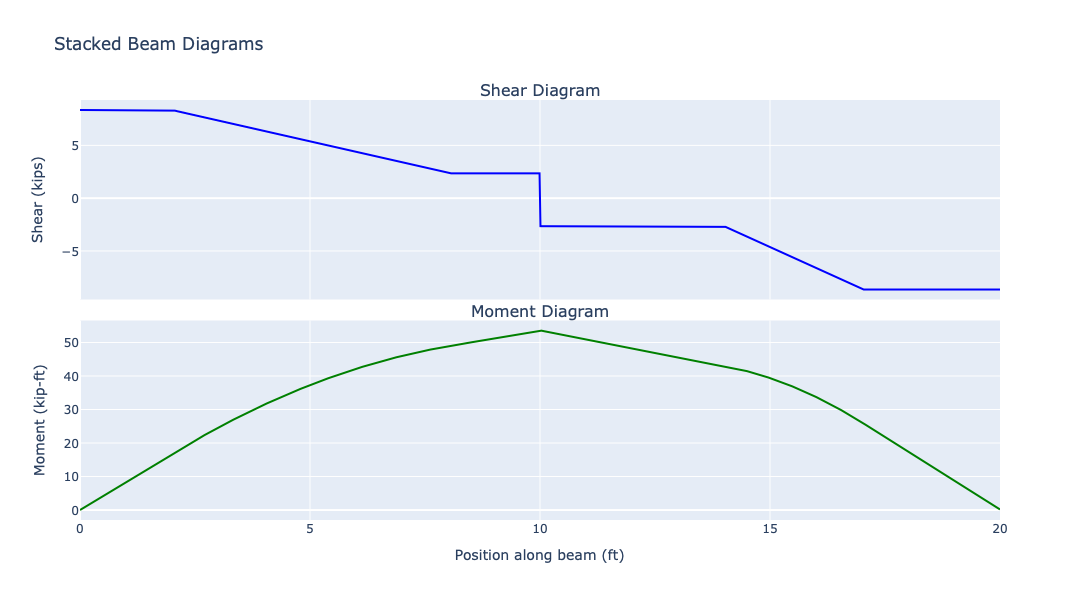

In [6]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display

# Single Python script for beam analysis with point and distributed loads in JupyterLab

def main():
    # Prompt for beam length
    beam_length = float(input("Enter beam length (ft): "))

    # Prompt for point loads
    loc_input = input("Enter locations of point loads from left end (ft), comma-separated (or none): ")
    point_loads = []
    if loc_input.lower() != 'none':
        locations = [float(l.strip()) for l in loc_input.split(',')]
        for loc in locations:
            Pu = float(input(f"Enter value of point load Pu at {loc} ft (kips): ")) * 1000  # Convert kips to pounds
            point_loads.append((loc, Pu))
        point_loads.sort(key=lambda x: x[0])

    # Prompt for distributed loads
    dist_loads = []
    while input("Add distributed load? (y/n): ").lower() == 'y':
        start = float(input("Enter start point of distributed load (ft): "))
        end = float(input("Enter end point of distributed load (ft): "))
        w = float(input(f"Enter distributed load magnitude (kips/ft): ")) * 1000  # Convert kips/ft to pounds/ft
        dist_loads.append((start, end, w))
    dist_loads.sort(key=lambda x: x[0])

    # Calculations for reactions, shear, and moment
    num_points = 1000
    x_ft = np.linspace(0, beam_length, num_points)

    # Compute reactions
    R_left = 0
    R_right = 0

    # Point load contributions to reactions
    for loc, Pu in point_loads:
        R_left += Pu * (beam_length - loc) / beam_length
        R_right += Pu * loc / beam_length

    # Distributed load contributions to reactions
    for start, end, w in dist_loads:
        length = end - start
        centroid = (start + end) / 2
        total_load = w * length
        R_left += total_load * (beam_length - centroid) / beam_length
        R_right += total_load * centroid / beam_length

    Vu = max(R_left, R_right) / 1000  # in kips

    # Shear diagram V(x) in kips
    V_arr = np.full(num_points, R_left / 1000)
    # Point loads
    for loc, Pu in point_loads:
        mask = x_ft > loc
        V_arr[mask] -= Pu / 1000
    # Distributed loads
    for start, end, w in dist_loads:
        mask = (x_ft >= start) & (x_ft <= end)
        V_arr[mask] -= w * (x_ft[mask] - start) / 1000
        mask_end = x_ft > end
        V_arr[mask_end] -= w * (end - start) / 1000

    # Moment diagram M(x) in kip-ft
    M_arr = np.zeros(num_points)
    for i in range(1, num_points):
        dx = x_ft[i] - x_ft[i-1]
        M_arr[i] = M_arr[i-1] + V_arr[i-1] * dx

    Mu = np.max(np.abs(M_arr))

    # Output: Print beam representation
    print("Beam Representation:")
    print("Simply Supported Beam:")
    print("A" + "-" * int(beam_length) + "B")
    for loc, Pu in point_loads:
        load_pos = int(loc)
        print(" " * load_pos + "↓ Pu = {:.2f} kips".format(Pu / 1000))
    for start, end, w in dist_loads:
        start_pos = int(start)
        print(" " * start_pos + "=" * int(end - start) + " w = {:.2f} kips/ft".format(w / 1000))

    # Print results
    print("\nResults:")
    print("Ultimate Moment Mu: {:.2f} kip-ft".format(Mu))
    print("Ultimate Shear Vu: {:.2f} kips".format(Vu))

    # Visualize with Plotly: Stacked subplots
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                        subplot_titles=('Shear Diagram', 'Moment Diagram'))

    # Shear
    fig.add_trace(go.Scatter(x=x_ft, y=V_arr, mode='lines', name='Shear (kips)', line=dict(color='blue')), row=1, col=1)

    # Moment
    fig.add_trace(go.Scatter(x=x_ft, y=M_arr, mode='lines', name='Moment (kip-ft)', line=dict(color='green')), row=2, col=1)

    fig.update_layout(height=600, title_text="Stacked Beam Diagrams", showlegend=False)
    fig.update_xaxes(title_text="Position along beam (ft)", row=2, col=1)
    fig.update_yaxes(title_text="Shear (kips)", row=1, col=1)
    fig.update_yaxes(title_text="Moment (kip-ft)", row=2, col=1)

    # Display plot in JupyterLab
    display(fig)

# Run the main function
main()